# Phân cụm văn bản báo tiếng việt

## Cài đặt và import các thư viện cần thiết

In [1]:
!pip install -qq pyvi sentence_transformers

In [2]:
import json
import os
import requests
import re
import torch
import numpy as np
from pprint import pprint
from pyvi import ViTokenizer
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
# Kiểm tra GPU có khả dụng không
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    raise RuntimeError("No GPU found")

print(f'Using device: {device}')

Using device: cuda


## Tiền xử lý dữ liệu

### Tải bộ văn bản báo tiếng việt về

In [4]:
# URL trực tiếp đến file JSON thô trên GitHub
url = 'https://raw.githubusercontent.com/nmquang003/AI4E/main/test_news_predicted.json'

# Tải nội dung của file
response = requests.get(url)

# Kiểm tra mã trạng thái phản hồi để đảm bảo rằng yêu cầu thành công
if response.status_code == 200:
    try:
        data = response.json()  # Đọc nội dung file JSON

        # Hiển thị phần tử đầu tiên của file JSON
        if isinstance(data, list) and len(data) > 0:
            pprint(json.dumps(data[0], indent=4, ensure_ascii=False))
        else:
            print("Dữ liệu JSON không phải là một danh sách hoặc danh sách trống.")

    except json.JSONDecodeError as e:
        print("JSONDecodeError: Không thể phân tích nội dung JSON.")
        print("Nội dung phản hồi không phải là JSON hợp lệ:")
        print(response.text)  # In ra nội dung phản hồi để kiểm tra
else:
    print(f"Yêu cầu thất bại với mã trạng thái {response.status_code}")
    print("Nội dung phản hồi:", response.text)

('{\n'
 '    "url": null,\n'
 '    "title": "Nhiều tháng đóng bảo hiểm xã hội bỗng \\"biến mất\\" trên ứng '
 'dụng quản lý",\n'
 '    "description": "Một số người lao động truy cập vào tài khoản bảo hiểm xã '
 'hội (BHXH) số - VssID thì thấy quá trình tham gia của mình \\"biến mất\\" '
 'nhiều tháng.",\n'
 '    "content": "Chị Ngọc Phương tham gia BHXh tự nguyện từ tháng 12/2021. '
 'Bắt đầu từ tháng 11/2023 đến nay, chị Phương tham gia BHXH bắt buộc tại công '
 'ty. Tuy nhiên, khi truy cập tài khoản VssID, chị Phương không thấy quá trình '
 'tham gia BHXH của mình được cập nhật.\\nCũng giống Phương, chị Thanh Tuyền '
 'tham gia BHXH từ tháng 7/2017 đến nay, trải qua 3 công ty và có 2 giai đoạn '
 'tạm ngừng tham gia. Tuy nhiên, khi truy cập tài khoản VssID, chị Tuyền phát '
 'hiện quá trình tham gia của mình thiếu mất giai đoạn làm việc ở công ty thứ '
 '2, kéo dài từ tháng 9/2021 đến tháng 3/2022.\\nMới đây, anh Tuấn (làm việc '
 'tại một công ty dịch vụ công ích ở TPHCM) truy cập t

In [5]:
print("Nội dung: ", data[0]['content'])
print("\nNhãn: ", data[0]['metadata']['cat'])

Nội dung:  Chị Ngọc Phương tham gia BHXh tự nguyện từ tháng 12/2021. Bắt đầu từ tháng 11/2023 đến nay, chị Phương tham gia BHXH bắt buộc tại công ty. Tuy nhiên, khi truy cập tài khoản VssID, chị Phương không thấy quá trình tham gia BHXH của mình được cập nhật.
Cũng giống Phương, chị Thanh Tuyền tham gia BHXH từ tháng 7/2017 đến nay, trải qua 3 công ty và có 2 giai đoạn tạm ngừng tham gia. Tuy nhiên, khi truy cập tài khoản VssID, chị Tuyền phát hiện quá trình tham gia của mình thiếu mất giai đoạn làm việc ở công ty thứ 2, kéo dài từ tháng 9/2021 đến tháng 3/2022.
Mới đây, anh Tuấn (làm việc tại một công ty dịch vụ công ích ở TPHCM) truy cập tài khoản VssID cũng thấy thiếu quá trình đóng BHXH từ tháng 8/2007 đến tháng 4/2009. Trong khi đó, trên tờ rời sổ BHXH bản giấy của anh Tuấn có quá trình này.
Chị Thanh Uyên bắt đầu đi làm và tham gia BHXH từ tháng 4/2007 đến nay, trải qua 7 công ty. Tuy nhiên, trên tài khoản VssID của chị không ghi nhận quá trình tham gia BHXH ở bất cứ công ty nào.

### Gộp các bài báo theo thể loại

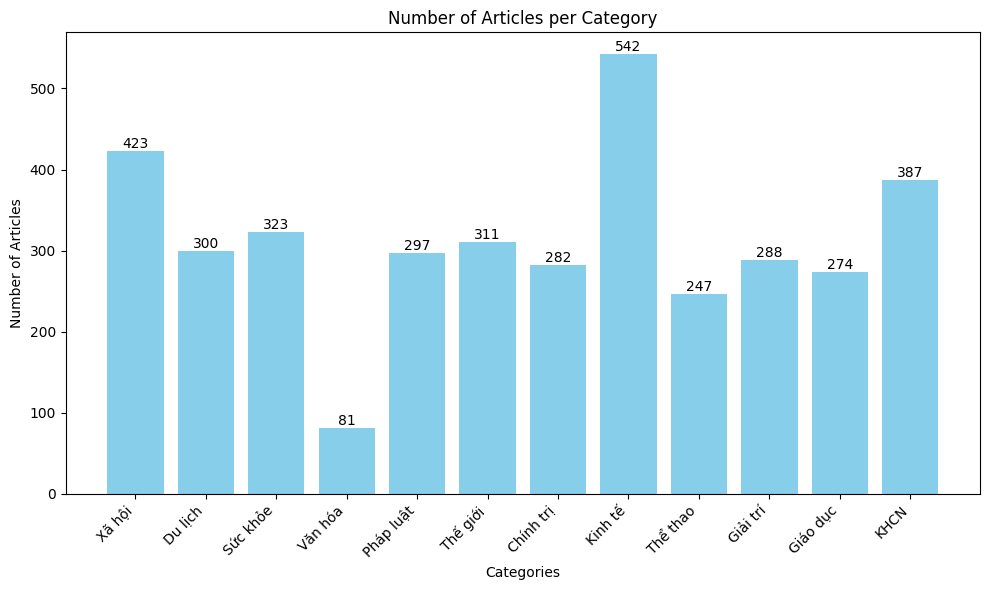

In [6]:
# Nhóm các bài báo theo nhãn
grouped_data = defaultdict(list)
for doc in data:
    cat = doc['metadata']['cat']
    grouped_data[cat].append({'title': doc['title'], 'content': doc['content']})

# Tính số lượng bài báo trong mỗi nhóm
group_counts = {cat: len(contents) for cat, contents in grouped_data.items()}

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(group_counts.keys(), group_counts.values(), color='skyblue')

# Thêm số lượng lên đỉnh mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Categories')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
# Chọn nhóm các bài báo lĩnh vực kinh tế để phân cụm
social_data = []

for doc in grouped_data['Xã hội']:
    social_data.append(doc['title'] + ' ' + doc['content'])

len(social_data)

423

### Làm sạch dữ liệu

In [8]:
# Danh sách stop words tiếng Việt (ví dụ)
stop_words = set([
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa",
    "chuyện", "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để",
    "đến", "điều", "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên",
    "lúc", "mà", "một", "này", "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những",
    "nơi", "nữa", "phải", "qua", "ra", "rằng", "rằng", "rất", "rồi", "sau", "sẽ", "so",
    "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng", "và", "vẫn", "vào", "vậy",
    "vì", "việc", "với"
])

### YOUR CODE START HERE ###

def preprocess(text):
    # Tokenize văn bản
    text = ViTokenizer.tokenize(text)
    # Loại bỏ ký tự đặc biệt
    text = re.sub(r'\W', ' ', text)
    # Chuyển về chữ thường
    text = text.lower()
    # Chia văn bản thành list các từ
    words = text.split()
    # Đếm số lượng từ
    original_count = len(words)
    # Loại bỏ stop words
    filtered_words = [word for word in words if word not in stop_words]
    # Đếm số lượng từ sau loại bỏ
    filtered_count = len(filtered_words)
    # Gộp các từ lại thành đoạn
    text = ' '.join(filtered_words)
    # Tính phần trăm stopword đã loại bỏ
    stopword_percentage = (original_count - filtered_count) / original_count * 100
    # Trả ra kết quả
    return text, stopword_percentage

### YOUR CODE END HERE ###


# Tiền xử lý nội dung các bài báo
total_stopword_percentage = 0
texts = []

for doc in tqdm(social_data, desc="Processing articles"):
    processed_content, stopword_percentage = preprocess(doc)
    texts.append(processed_content)
    total_stopword_percentage += stopword_percentage

average_stopword_percentage = total_stopword_percentage / len(social_data) * 100

print(f"Average percentage of stop words removed: {average_stopword_percentage:.2f}%")

Processing articles:   0%|          | 0/423 [00:00<?, ?it/s]

Average percentage of stop words removed: 2473.69%


In [9]:
print(texts[0])

tháng đóng bảo_hiểm xã_hội bỗng biến mất ứng_dụng quản_lý chị ngọc_phương tham_gia bhxh tự_nguyện tháng 12 2021 bắt_đầu_từ tháng 11 2023 nay chị phương tham_gia bhxh bắt_buộc công_ty tuy_nhiên truy_cập tài_khoản vssid chị phương thấy quá_trình tham_gia bhxh mình cập_nhật giống phương chị thanh_tuyền tham_gia bhxh tháng 7 2017 nay trải 3 công_ty 2 giai_đoạn tạm ngừng tham_gia tuy_nhiên truy_cập tài_khoản vssid chị tuyền phát_hiện quá_trình tham_gia mình thiếu mất giai_đoạn làm_việc ở công_ty thứ 2 kéo_dài tháng 9 2021 tháng 3 2022 mới_đây anh tuấn làm_việc công_ty dịch_vụ công_ích ở tphcm truy_cập tài_khoản vssid thấy thiếu quá_trình đóng bhxh tháng 8 2007 tháng 4 2009 trong tờ rời sổ bhxh bản giấy anh tuấn quá_trình chị thanh_uyên bắt_đầu đi làm tham_gia bhxh tháng 4 2007 nay trải 7 công_ty tuy_nhiên tài_khoản vssid chị ghi_nhận quá_trình tham_gia bhxh ở bất_cứ công_ty nào chị ngọc_phương lo_lắng quá_trình tham_gia vssid bây_giờ tôi nghỉ_việc làm đơn xin hưởng bảo_hiểm_thất_nghiệp vssi

### Trích chọn đặc trưng, tạo vector biểu diễn cho dữ liệu

#### Dùng TF-IDF

In [10]:
# # Vectorize texts using TF-IDF for SVM
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
# economics_embeddings = tfidf_vectorizer.fit_transform(texts)

# economics_embeddings = economics_embeddings.toarray()
# print(economics_embeddings.shape)

#### Dùng SBert

In [11]:
from sentence_transformers import SentenceTransformer

# Chọn mô hình và chuyển sang GPU
model = SentenceTransformer('keepitreal/vietnamese-sbert', device=device)

/home/ltpq/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


2024-08-21 19:04:54.683568: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 19:04:54.712343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-08-21 19:04:55.130467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/ltpq/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
# ví dụ
enc = model.encode('xin chào')
print(enc.shape)
print(enc)

(768,)
[ 4.03795391e-01  5.39230764e-01 -5.04004896e-01 -7.17044473e-01
  1.07034892e-01 -2.92842567e-01 -4.59062494e-02  1.52295217e-01
 -2.34072953e-01 -1.54185370e-01  1.17455214e-01  4.30376709e-01
  9.63170826e-02  1.83036506e-01  7.68422261e-02  1.74694210e-01
  5.25178909e-02 -4.52809706e-02  1.42724842e-01 -6.85166344e-02
 -1.18663006e-01 -6.38732553e-01  4.99835044e-01 -4.58089620e-01
 -9.92408395e-02 -4.88896430e-01 -2.52603125e-02  4.34167944e-02
 -5.65652370e-01  1.12226695e-01  2.30188519e-01  8.20210427e-02
  1.53543670e-02  3.64027530e-01  9.53538179e-01  6.19501233e-01
 -1.63106173e-01  3.23149681e-01  5.45238495e-01  7.96736002e-01
  1.33982927e-01 -2.79224571e-02  7.80682325e-01  9.98718888e-02
 -4.42460589e-02  3.56377028e-02 -2.68451512e-01 -5.08545518e-01
  3.80318575e-02 -3.78400311e-02  9.80227217e-02 -1.67623699e-01
 -2.87249126e-02  4.09534484e-01 -4.92820814e-02  1.77344412e-01
 -2.85189480e-01  3.29363167e-01 -3.32213342e-01  1.07594542e-01
 -2.70092010e-01  

In [13]:
# Tạo vector biểu diễn cho từng bài báo với tiến độ
economics_embeddings = []

for content in tqdm(texts, desc=f"Encoding articles ", unit='article'):
    embedding = model.encode(content)
    economics_embeddings.append(embedding)

Encoding articles :   0%|          | 0/423 [00:00<?, ?article/s]

## Chạy các thuật toán phân cụm

### Hàm đánh giá chất lượng phân cụm

In [14]:
import warnings
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Tắt tất cả các cảnh báo FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

def evaluate_clustering(embeddings, labels, model=None):
    sil_score = silhouette_score(embeddings, labels)
    db_score = davies_bouldin_score(embeddings, labels)
    ch_score = calinski_harabasz_score(embeddings, labels)

    # Tính WCSS nếu có model KMeans
    wcss = None
    if model and hasattr(model, 'inertia_'):
        wcss = model.inertia_

    return sil_score, db_score, ch_score, wcss

### Hàm chạy thuật toán phân cụm và đánh giá chất lượng phân cụm

In [15]:
# Chạy và đánh giá chất lượng phân cụm
def cluster_and_evaluate(embeddings, n_clusters_list):
    results = {n: {} for n in n_clusters_list}

    for n_clusters in tqdm(n_clusters_list, desc="Clustering and evaluating"):
        # K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
        kmeans_labels = kmeans.labels_
        results[n_clusters]['kmeans'] = evaluate_clustering(embeddings, kmeans_labels, model=kmeans)

        # EM (GMM)
        gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(embeddings)
        gmm_labels = gmm.predict(embeddings)
        results[n_clusters]['gmm'] = evaluate_clustering(embeddings, gmm_labels)

        # Hierarchical Clustering
        hier = AgglomerativeClustering(n_clusters=n_clusters).fit(embeddings)
        hier_labels = hier.labels_
        results[n_clusters]['hierarchical'] = evaluate_clustering(embeddings, hier_labels)


    return results

### Chạy thuật các thuật toán phân cụm

In [16]:
# # Khởi tạo từ điển để ưu kết quả
cluster_results = {}

In [17]:
FLAG = 0
try:
    with open("flag.txt", "r") as f:
      print("File exists!")
except IOError:
    with open("flag.txt", "w") as f:
        f.write("0")
finally:
    with open("flag.txt", "r") as f:
        FLAG = int(f.read())

File exists!


In [18]:
if FLAG == 0:
  n_clusters_list = range(2, 100)
  n_clusters_to_run = [n for n in n_clusters_list if n not in cluster_results]

  # Chạy phân cụm và đánh giá với các giá trị n_clusters mới
  if n_clusters_to_run:
      new_cluster_results = cluster_and_evaluate(economics_embeddings, n_clusters_to_run)
      # Hợp nhất kết quả mới vào kết quả cũ
      cluster_results.update(new_cluster_results)
  else:
      print("All n_clusters in the list have already been evaluated.")

In [19]:
for i in range(2,100): 
  if i not in cluster_results: cluster_results[i] = {}

In [20]:
for i in range(2,100): 
  try: cluster_results[i].pop('dbscan')
  except: pass

### Tìm tham số phù hợp cho DBSCAN để nó có thể output ra số lượng cụm khác nhau

Do binary search to find (theoretically) all possible number of clusters. 

In [21]:
if FLAG == 0:
  embeddings = economics_embeddings
  for min_samples in range(2,26):
      last_clusters = 1
      while last_clusters < 100:
        low = 10**(-6)
        high = 50
        num_iters = 75
        opt_eps = -1
        for _ in range(num_iters):
          mid = (low + high) / 2
          dens = DBSCAN(eps=mid, min_samples=min_samples).fit(embeddings)
          dens_labels = dens.fit_predict(embeddings)
          n_clusters = len(set(dens_labels)) - (1 if -1 in dens_labels else 0)
          if n_clusters <= last_clusters: high = mid
          else: low, opt_eps = mid,mid
        if opt_eps == -1: break
        dens = DBSCAN(eps=opt_eps, min_samples=min_samples).fit(embeddings)
        dens_labels = dens.fit_predict(embeddings)
        n_clusters = len(set(dens_labels)) - (1 if -1 in dens_labels else 0)
        if cluster_results[n_clusters].get('dbscan') is None:
          print(f"num_labels: {len(set(dens_labels))}, min_samples: {min_samples}, epsilon: {opt_eps}")
          cluster_results[n_clusters]['dbscan'] = evaluate_clustering(embeddings, dens_labels)
        last_clusters = n_clusters

If the monotonicity assumption is incorrect

In [ ]:
if FLAG == 0:
  embeddings = economics_embeddings
  for min_samples in range(2,26):
      STEP = 10**-4
      eps = 0
      while eps <= 10:
        eps += STEP
        dens = DBSCAN(eps=eps, min_samples=min_samples).fit(embeddings)
        dens_labels = dens.fit_predict(embeddings)
        n_clusters = len(set(dens_labels)) - (1 if -1 in dens_labels else 0)
        if 2 <= n_clusters < 100: 
            if cluster_results[n_clusters].get('dbscan') is None:
                print(f"num_labels: {len(set(dens_labels))}, min_samples: {min_samples}, epsilon: {eps}")
                cluster_results[n_clusters]['dbscan'] = evaluate_clustering(embeddings, dens_labels)

In [ ]:
if FLAG == 0:
  embeddings = economics_embeddings
  for min_samples in range(2,26):
      last_clusters = 1
      while last_clusters < 100:
        STEP = 10**-4
        eps = STEP
        while eps <= 10:
          low = 10**(-6)
          high = 50
          num_iters = 75
          opt_eps = -1
          for _ in range(num_iters):
            mid = (low + high) / 2
            dens = DBSCAN(eps=mid, min_samples=min_samples).fit(embeddings)
            dens_labels = dens.fit_predict(embeddings)
            n_clusters = len(set(dens_labels)) - (1 if -1 in dens_labels else 0)
            if n_clusters <= last_clusters: high = mid
            else: low, opt_eps = mid,mid
          if opt_eps == -1: break
          dens = DBSCAN(eps=opt_eps, min_samples=min_samples).fit(embeddings)
          dens_labels = dens.fit_predict(embeddings)
          n_clusters = len(set(dens_labels)) - (1 if -1 in dens_labels else 0)
          if cluster_results[n_clusters].get('dbscan') is None:
            print(f"num_labels: {len(set(dens_labels))}, min_samples: {min_samples}, epsilon: {opt_eps}")
            cluster_results[n_clusters]['dbscan'] = evaluate_clustering(embeddings, dens_labels)
          last_clusters = n_clusters

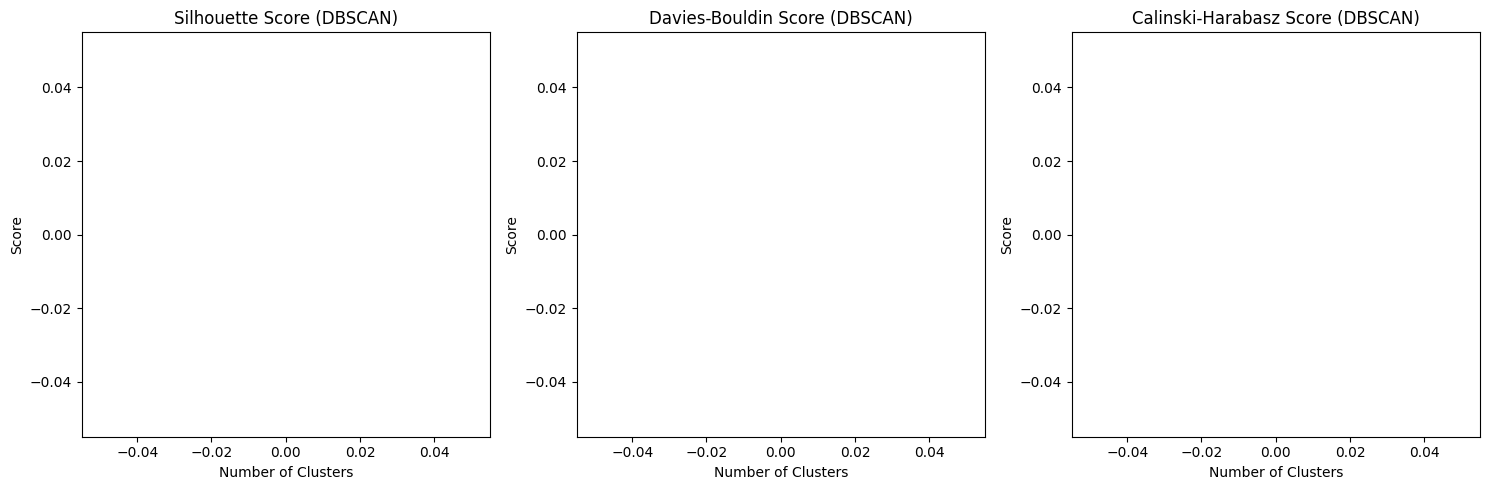

In [22]:
# prompt: plot for dbscan
try:
# Vẽ biểu đồ đánh giá DBSCAN
  dbscan_results = {n: result.get('dbscan') for n, result in cluster_results.items() if result.get('dbscan') is not None}

  # Lấy ra các giá trị số liệu
  n_clusters_dbscan = list(dbscan_results.keys())
  sil_scores_dbscan = [result[0] for result in dbscan_results.values()]
  db_scores_dbscan = [result[1] for result in dbscan_results.values()]
  ch_scores_dbscan = [result[2] for result in dbscan_results.values()]

  # Vẽ biểu đồ
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  axs[0].plot(n_clusters_dbscan, sil_scores_dbscan, marker='o')
  axs[0].set_title('Silhouette Score (DBSCAN)')
  axs[0].set_xlabel('Number of Clusters')
  axs[0].set_ylabel('Score')

  axs[1].plot(n_clusters_dbscan, db_scores_dbscan, marker='o')
  axs[1].set_title('Davies-Bouldin Score (DBSCAN)')
  axs[1].set_xlabel('Number of Clusters')
  axs[1].set_ylabel('Score')

  axs[2].plot(n_clusters_dbscan, ch_scores_dbscan, marker='o')
  axs[2].set_title('Calinski-Harabasz Score (DBSCAN)')
  axs[2].set_xlabel('Number of Clusters')
  axs[2].set_ylabel('Score')

  plt.tight_layout()
  plt.savefig('dbscan_evaluation_results.png')
  plt.show()
except:
  pass


### Vẽ biểu đồ

In [23]:
# Hàm vẽ biểu đồ kết quả đánh giá
def plot_evaluation_results(metrics_dict):
    n_clusters_list = sorted(metrics_dict.keys())

    algorithms = ['kmeans', 'gmm', 'hierarchical', 'dbscan']
    metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=False)

    for i, metric in enumerate(metrics):
        ax = axs[i]
        y_limit = -100
        for algo in algorithms:
            indices = [n for n in n_clusters_list if metrics_dict[n].get(algo, -1) != -1]
            scores = [metrics_dict[n][algo][i] for n in indices]
            y_limit = max(y_limit, max(scores))
            ax.plot(indices, scores, label=algo)

        ax.set_title(metric)
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Score')
        ax.legend()
        ax.set_ylim(0, y_limit * 1.1)
        
    plt.tight_layout()
    plt.savefig('evaluation_results.png')
    plt.show()

# Vẽ biểu đồ đánh giá
if FLAG == 0:
  plot_evaluation_results(cluster_results)

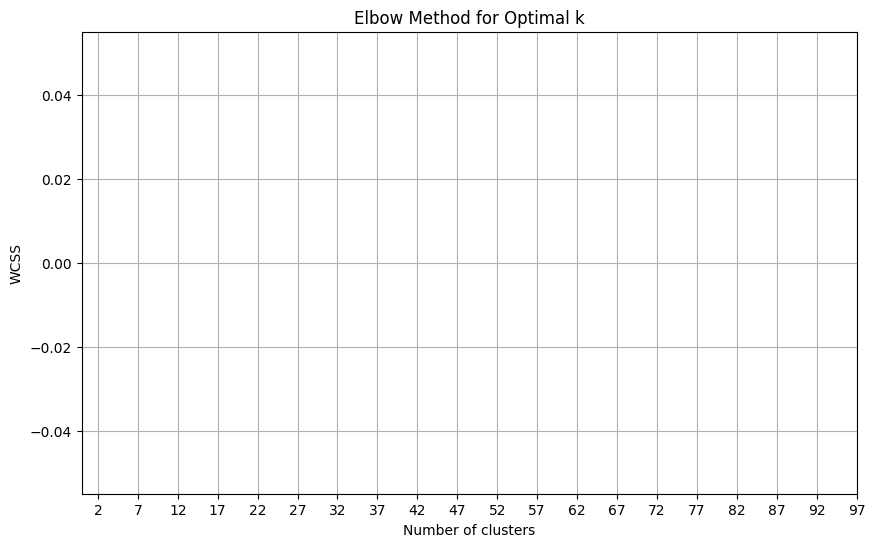

In [24]:
# Vẽ đồ thị Elbow
n_list = sorted(cluster_results.keys())
indices = [n for n in n_list if cluster_results[n].get('kmeans', -1) != -1]
scores = [cluster_results[n]['kmeans'][3] for n in indices]

plt.figure(figsize=(10, 6))
plt.plot(indices, scores, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(list(range(2,100,5)))
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

### Lưu trữ các model đã training

In [25]:
if FLAG == 0:
  with open("flag.txt", "w") as f:
      f.write("1")

### Huấn luyện với số lượng cụm và thuật toán tối ưu

In [26]:
if FLAG == 1:
  # Lựa chọn số cụm tối ưu
  optimal_n_clusters = 50
  # Lựa chọn model tối ưu
  model = AgglomerativeClustering(n_clusters=optimal_n_clusters).fit(economics_embeddings)
  labels = model.fit_predict(economics_embeddings)


### Minh họa việc phát hiện chủ đề

---



Minh họa phân cụm trên không gian 2 chiều

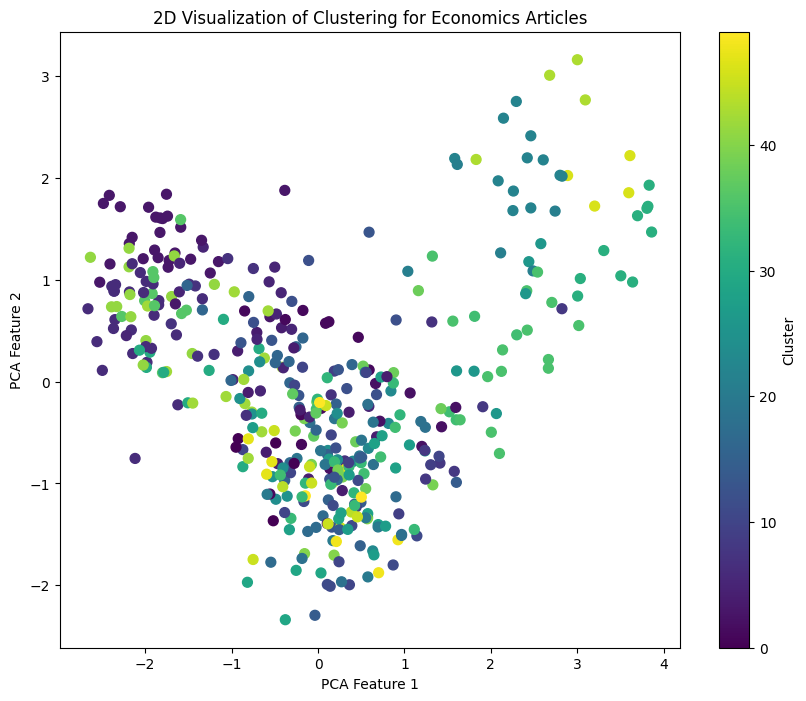

In [27]:
from sklearn.decomposition import PCA
if FLAG == 1:
  # Áp dụng PCA để giảm chiều dữ liệu xuống 2 chiều
  # Giảm chiều dữ liệu xuống 2D bằng PCA
  pca = PCA(n_components=2)
  reduced_embeddings = pca.fit_transform(economics_embeddings)

  # Vẽ minh họa việc phân cụm trên đồ thị 2D
  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', marker='o', s=50)
  plt.colorbar(scatter, label='Cluster')
  plt.title('2D Visualization of Clustering for Economics Articles')
  plt.xlabel('PCA Feature 1')
  plt.ylabel('PCA Feature 2')
  plt.savefig('2d_visualization.png')
  plt.show()

Minh họa việc phát hiện chủ đề

In [28]:
# Thay `chosen_cluster` bằng số cụm bạn muốn kiểm tra, số bắt đầu từ 0 đến n_clusters - 1
if FLAG == 1:
  inspect_results = {}
  for chosen_cluster in range(2,100):
    # Lọc các bài báo thuộc cụm đã chọn
    chosen_cluster_indices = [i for i, label in enumerate(labels) if label == chosen_cluster]
    chosen_articles = [social_data[i] for i in chosen_cluster_indices]

    # In ra nội dung của 3 bài báo đầu tiên trong cụm đã chọn
    print(f"Nội dung của 3 bài báo trong cụm {chosen_cluster}:")
    for i, article in enumerate(chosen_articles[:3]):
        print(f"Bài báo {i+1}:")
        print(article)
        print("-" * 80)
    inspect_results[chosen_cluster] = chosen_articles
  json.dump(inspect_results, open("inspect_results.json", "w", encoding="utf-8"))


Nội dung của 3 bài báo trong cụm 2:
Bài báo 1:
Tỷ lệ lao động trẻ em của Việt Nam thấp hơn 4% trung bình toàn cầu Thông tin này được ông Đặng Hoa Nam, Cục trưởng Cục Trẻ em, Bộ LĐ-TB&XH nêu tại hội thảo "Phòng ngừa, giảm thiểu trẻ em lao động trái quy định của pháp luật năm 2024", ngày 11/6.
Hội thảo được tổ chức để đại diện các bộ, ngành trung ương và địa phương, cùng các nhà nghiên cứu, chuyên gia về lĩnh vực trẻ em tập trung thảo luận, đưa ra các giải pháp nhằm phòng ngừa, giảm thiểu trẻ em lao động trái quy định của pháp luật.
Hội thảo "Phòng ngừa, giảm thiểu trẻ em lao động trái quy định của pháp luật năm 2024" diễn ra ngày 11/6 (Ảnh: Gia Đoàn).
Hội thảo cũng góp phần hưởng ứng Tháng hành động vì trẻ em năm 2024 với chủ đề "Hành động thiết thực, ưu tiên nguồn lực cho trẻ em" và Ngày phòng, chống lao động trẻ em quốc tế năm 2024.
Phát biểu tại hội thảo, Cục trưởng Cục Trẻ em Đặng Hoa Nam cho biết, Việt Nam có khoảng 1,7 triệu trẻ em tham gia hoạt động kinh tế, chiếm 9,1% tổng số tr